# Assignment: Xarray Fundamentals with Atmospheric Radiation Data

In this assignment, we will use Xarray to analyze top-of-atmosphere radiation data from [NASA's CERES project](https://ceres.larc.nasa.gov/).

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/The-NASA-Earth%27s-Energy-Budget-Poster-Radiant-Energy-System-satellite-infrared-radiation-fluxes.jpg" width=65%>

_Public domain, by NASA, from Wikimedia Commons_


A pre-downloaded CERES dataset is available here: doi:10.5281/zenodo.13983633.

Please review the CERES [FAQs](https://ceres.larc.nasa.gov/resources/faqs) before getting started.

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

Next, download the NetCDF file using pooch.

In [3]:
import pooch
doi = "doi:10.5281/zenodo.13983633"
fname = "CERES_EBAF-TOA_ Ed2p8.nc"
CERES_file = pooch.retrieve(
    url=f"{doi}/{fname}",
    known_hash="md5:6f3ef92a9dfd744b5d6ce4af4b3571c8",
)
CERES_file

'/home/jovyan/.cache/pooch/68e15bd706b5e5ec74000b516a10148e-CERES_EBAF-TOA_ Ed2p8.nc'

## 1) Opening data and examining metadata

### 1.1) Open the dataset and display its contents 
You may need to set `decode_times=False`.

In [4]:
da = xr.open_dataset(CERES_file, decode_times=False)
da

<xarray.Dataset> Size: 474MB
Dimensions:          (lat: 180, lon: 360, time: 183)
Coordinates:
  * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 1kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * time             (time) float32 732B 482.5 483.5 484.5 ... 662.5 663.5 664.5
Data variables:
    solar_mon        (time, lat, lon) float32 47MB ...
    toa_cre_lw_mon   (time, lat, lon) float32 47MB ...
    toa_cre_net_mon  (time, lat, lon) float32 47MB ...
    toa_cre_sw_mon   (time, lat, lon) float32 47MB ...
    toa_lw_all_mon   (time, lat, lon) float32 47MB ...
    toa_lw_clr_mon   (time, lat, lon) float32 47MB ...
    toa_net_all_mon  (time, lat, lon) float32 47MB ...
    toa_net_clr_mon  (time, lat, lon) float32 47MB ...
    toa_sw_all_mon   (time, lat, lon) float32 47MB ...
    toa_sw_clr_mon   (time, lat, lon) float32 47MB ...
Attributes:
    references:   Loeb_etal2009
    version:      This is version 2.8: August 21, 2015
    comment:      Data is from East to West and South to North. Climatology f...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    description:  Edition 2.8
    Fill_Value:   Fill Value is -999.0

### 1.2) Print out the `long_name` attribute of each variable
Print `variable`: `long name` for each variable. Format the output so that the start of the `long name` attributes are aligned. 

In [5]:
for i,j in da.data_vars.items():
    long_name = j.attrs.get('long_name')
    print(f"{i:<20}", long_name)

solar_mon            Incoming Solar Flux, Monthly Means
toa_cre_lw_mon       Top of The Atmosphere Cloud Radiative Effects Longwave Flux, Monthly Means
toa_cre_net_mon      Top of The Atmosphere Cloud Radiative Effects Net Flux, Monthly Means
toa_cre_sw_mon       Top of The Atmosphere Cloud Radiative Effects Shortwave Flux, Monthly Means
toa_lw_all_mon       Top of The Atmosphere Longwave Flux, Monthly Means, All-Sky conditions
toa_lw_clr_mon       Top of The Atmosphere Longwave Flux, Monthly Means, Clear-Sky conditions
toa_net_all_mon      Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions
toa_net_clr_mon      Top of The Atmosphere Net Flux, Monthly Means, Clear-Sky conditions
toa_sw_all_mon       Top of The Atmosphere Shortwave Flux, Monthly Means, All-Sky conditions
toa_sw_clr_mon       Top of The Atmosphere Shortwave Flux, Monthly Means, Clear-Sky conditions


## 2) Basic reductions, arithmetic, and plotting

### 2.1) Calculate the time-mean of the entire dataset

In [6]:
time_mean = da['time'].mean()
time_mean

<xarray.DataArray 'time' ()> Size: 4B
array(573.5, dtype=float32)

### 2.2) From this, make a 2D plot of the the time-mean Top of Atmosphere (TOA) Longwave, Shortwave, and Incoming Solar Radiation
(Use "All-Sky" conditions)

Note the sign conventions on each variable.

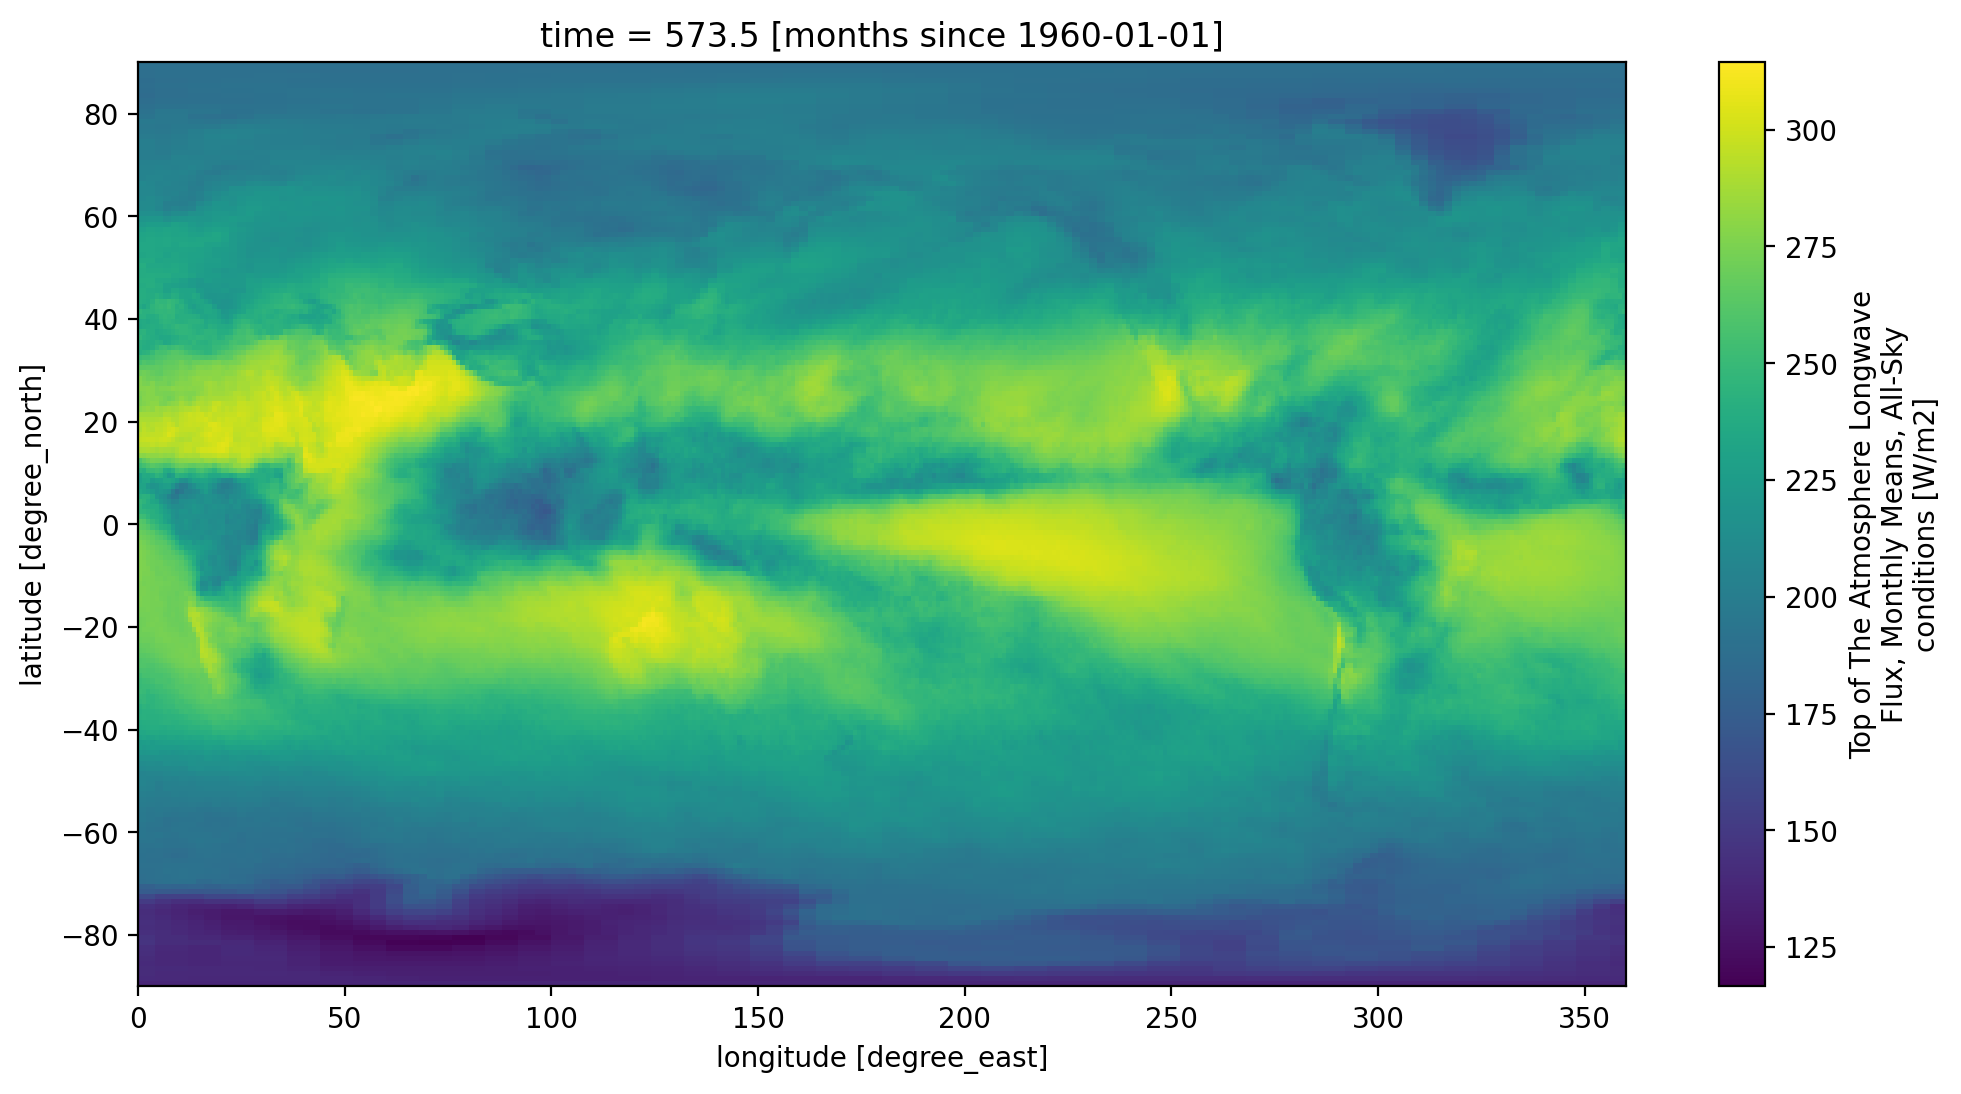

In [7]:
da.toa_lw_all_mon.sel(time=time_mean).plot()

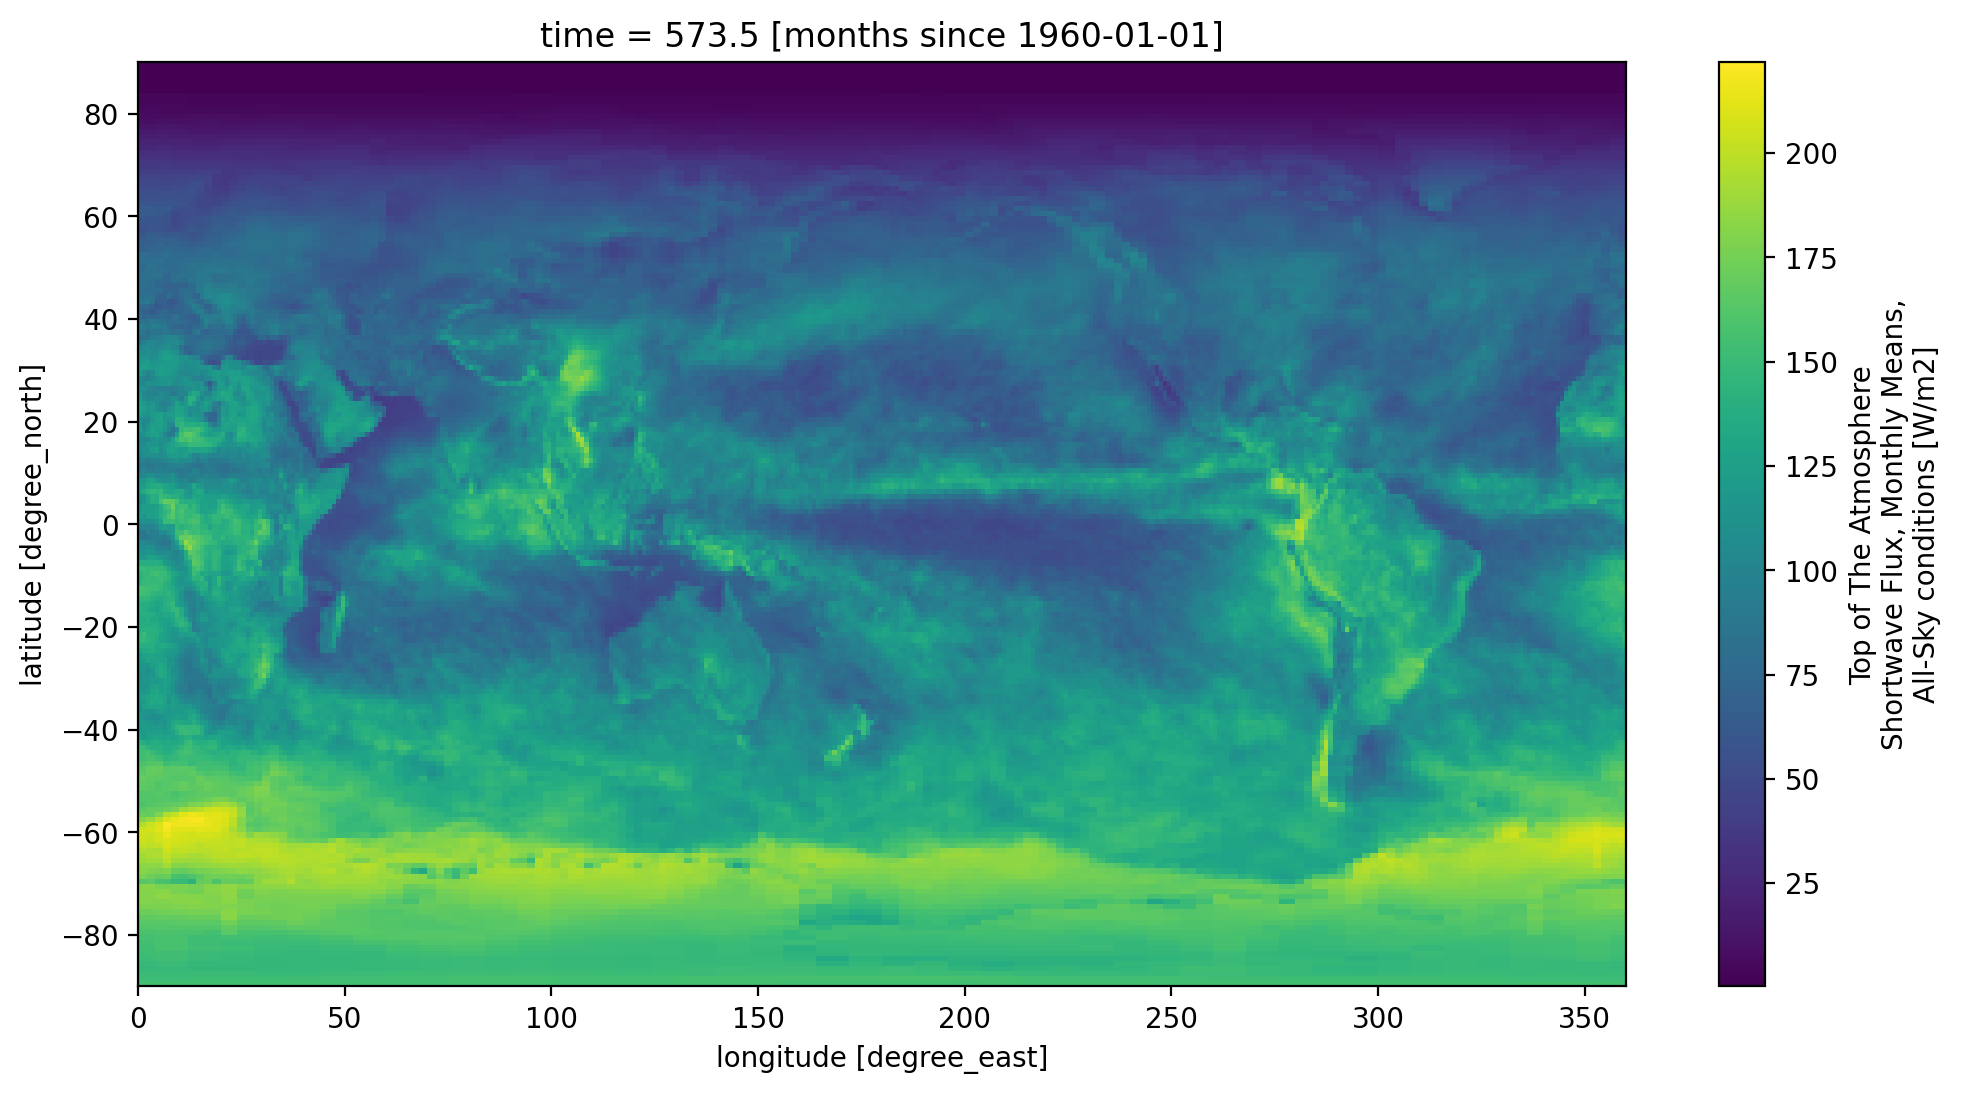

In [8]:
da.toa_sw_all_mon.sel(time=time_mean).plot()

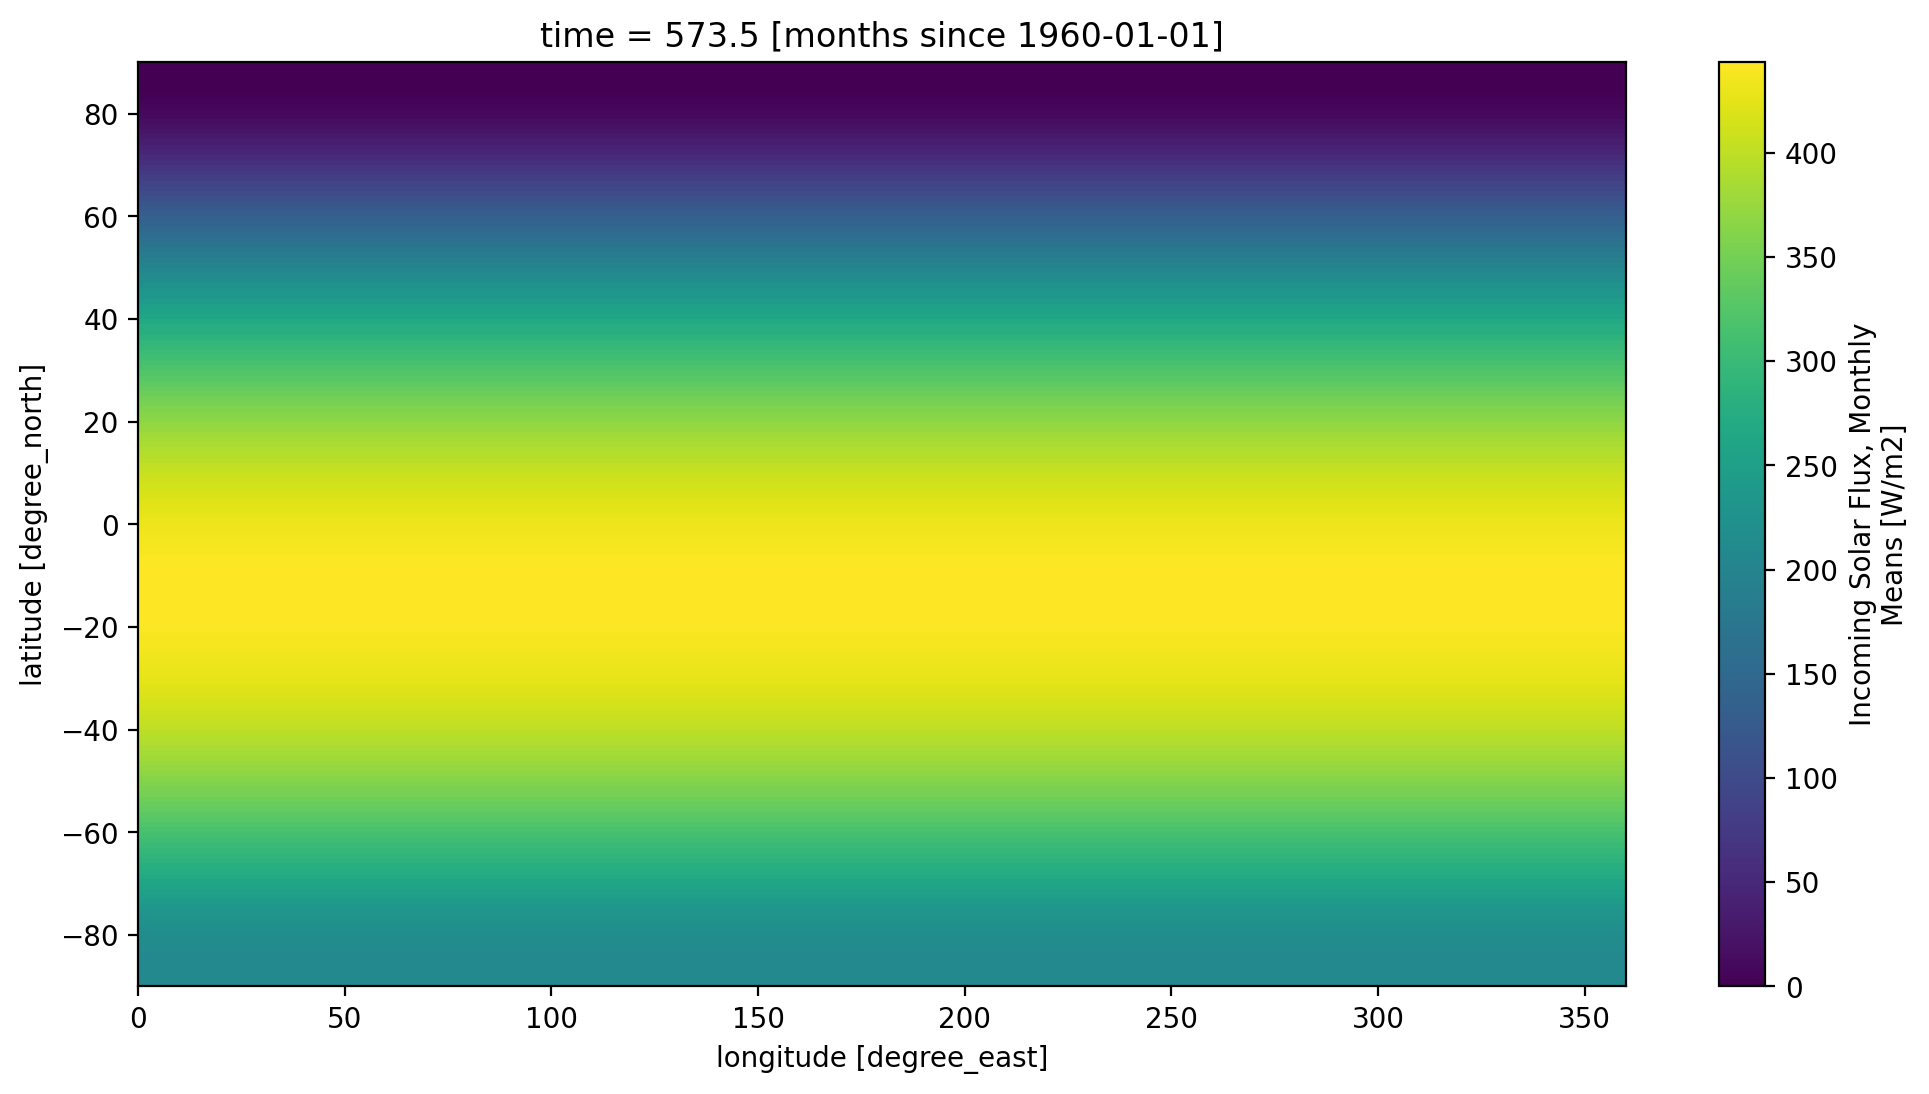

In [9]:
da.solar_mon.sel(time=time_mean).plot()

### 2.3) Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux

You have to pay attention to and think carefully about the sign conventions (positive or negative) for each variable in order for the variables to sum to the right TOA net flux. Refer to the NASA figure at the top of the page to understand incoming and outgoing radiation.

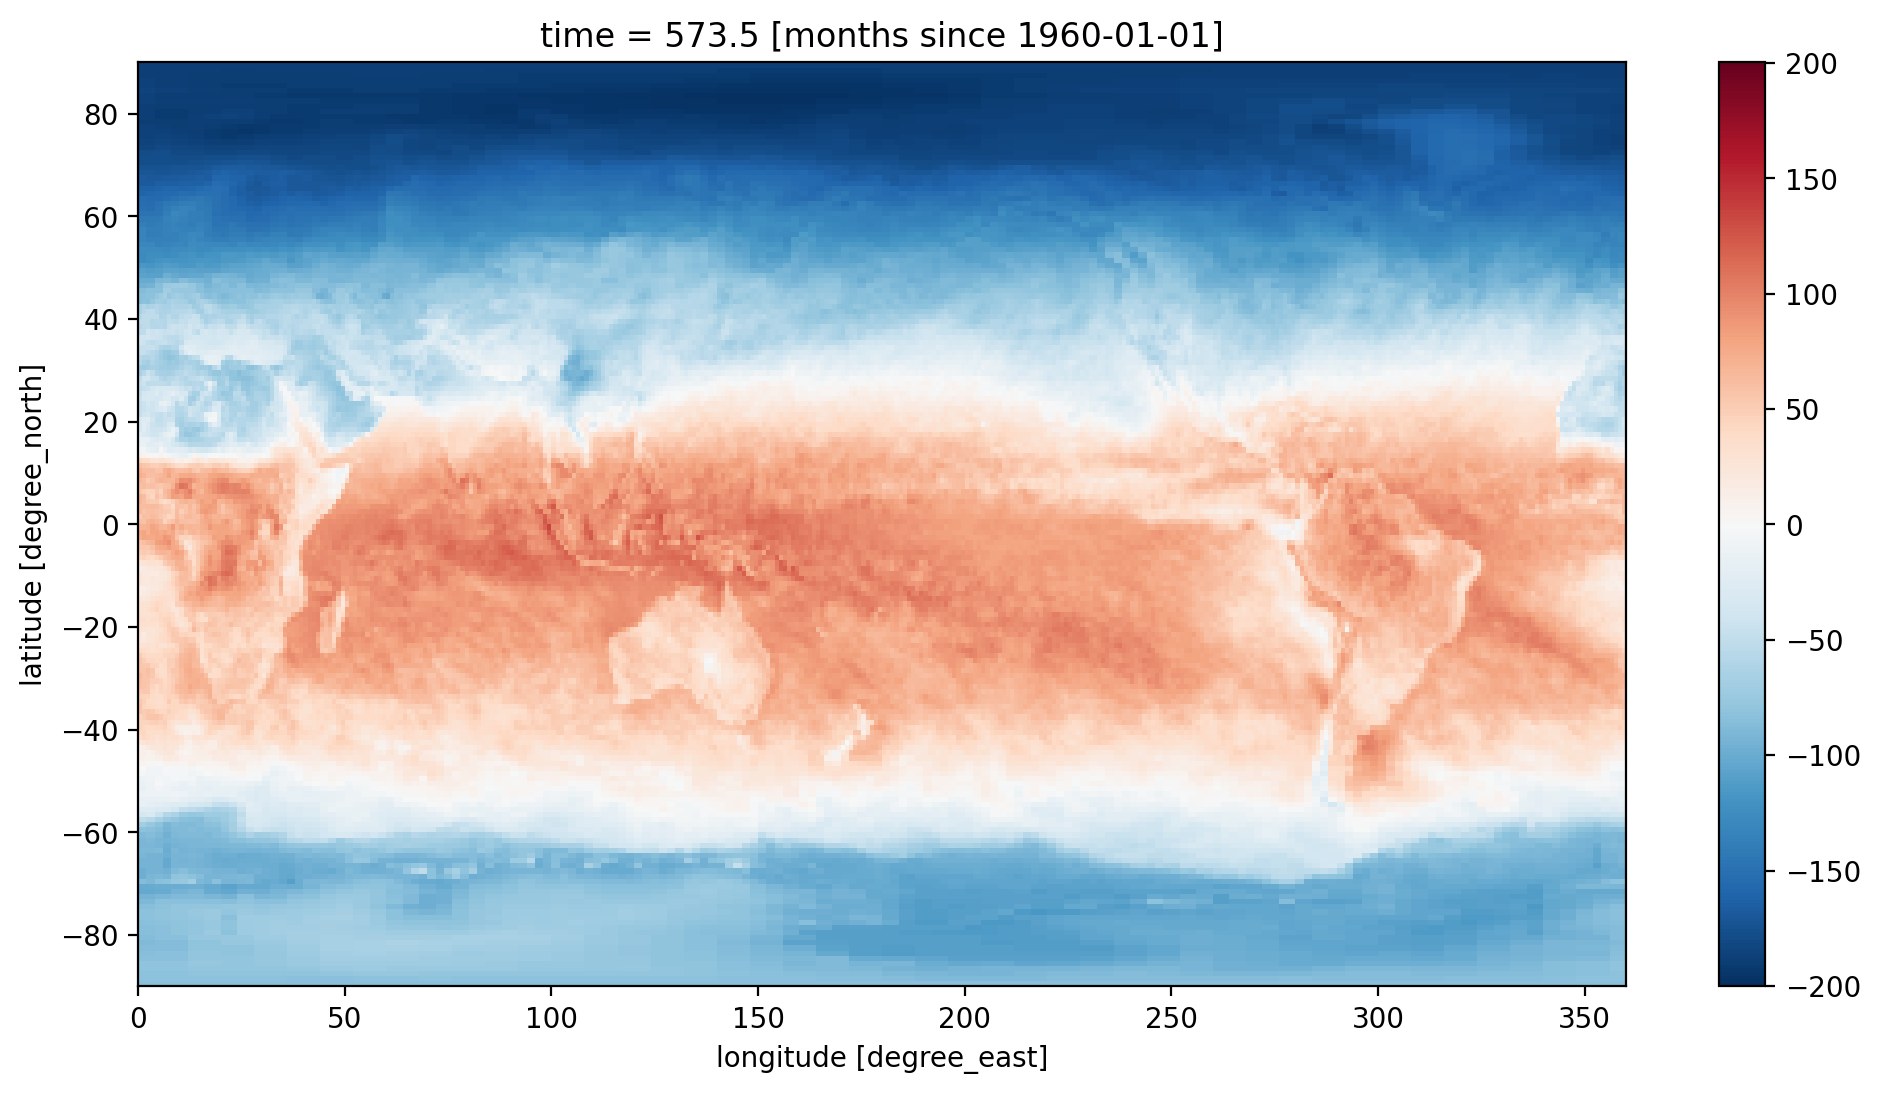

In [10]:
net =  -da['toa_lw_all_mon'] - da['toa_sw_all_mon'] + da['solar_mon']
net.sel(time=time_mean).plot()

'\nnet_data_slice = net.isel(time=0)\nplt.imshow(net_data_slice,vmin=-200, vmax=200)\n\ncbar = plt.colorbar()\ncbar.ax.invert_yaxis()\n'

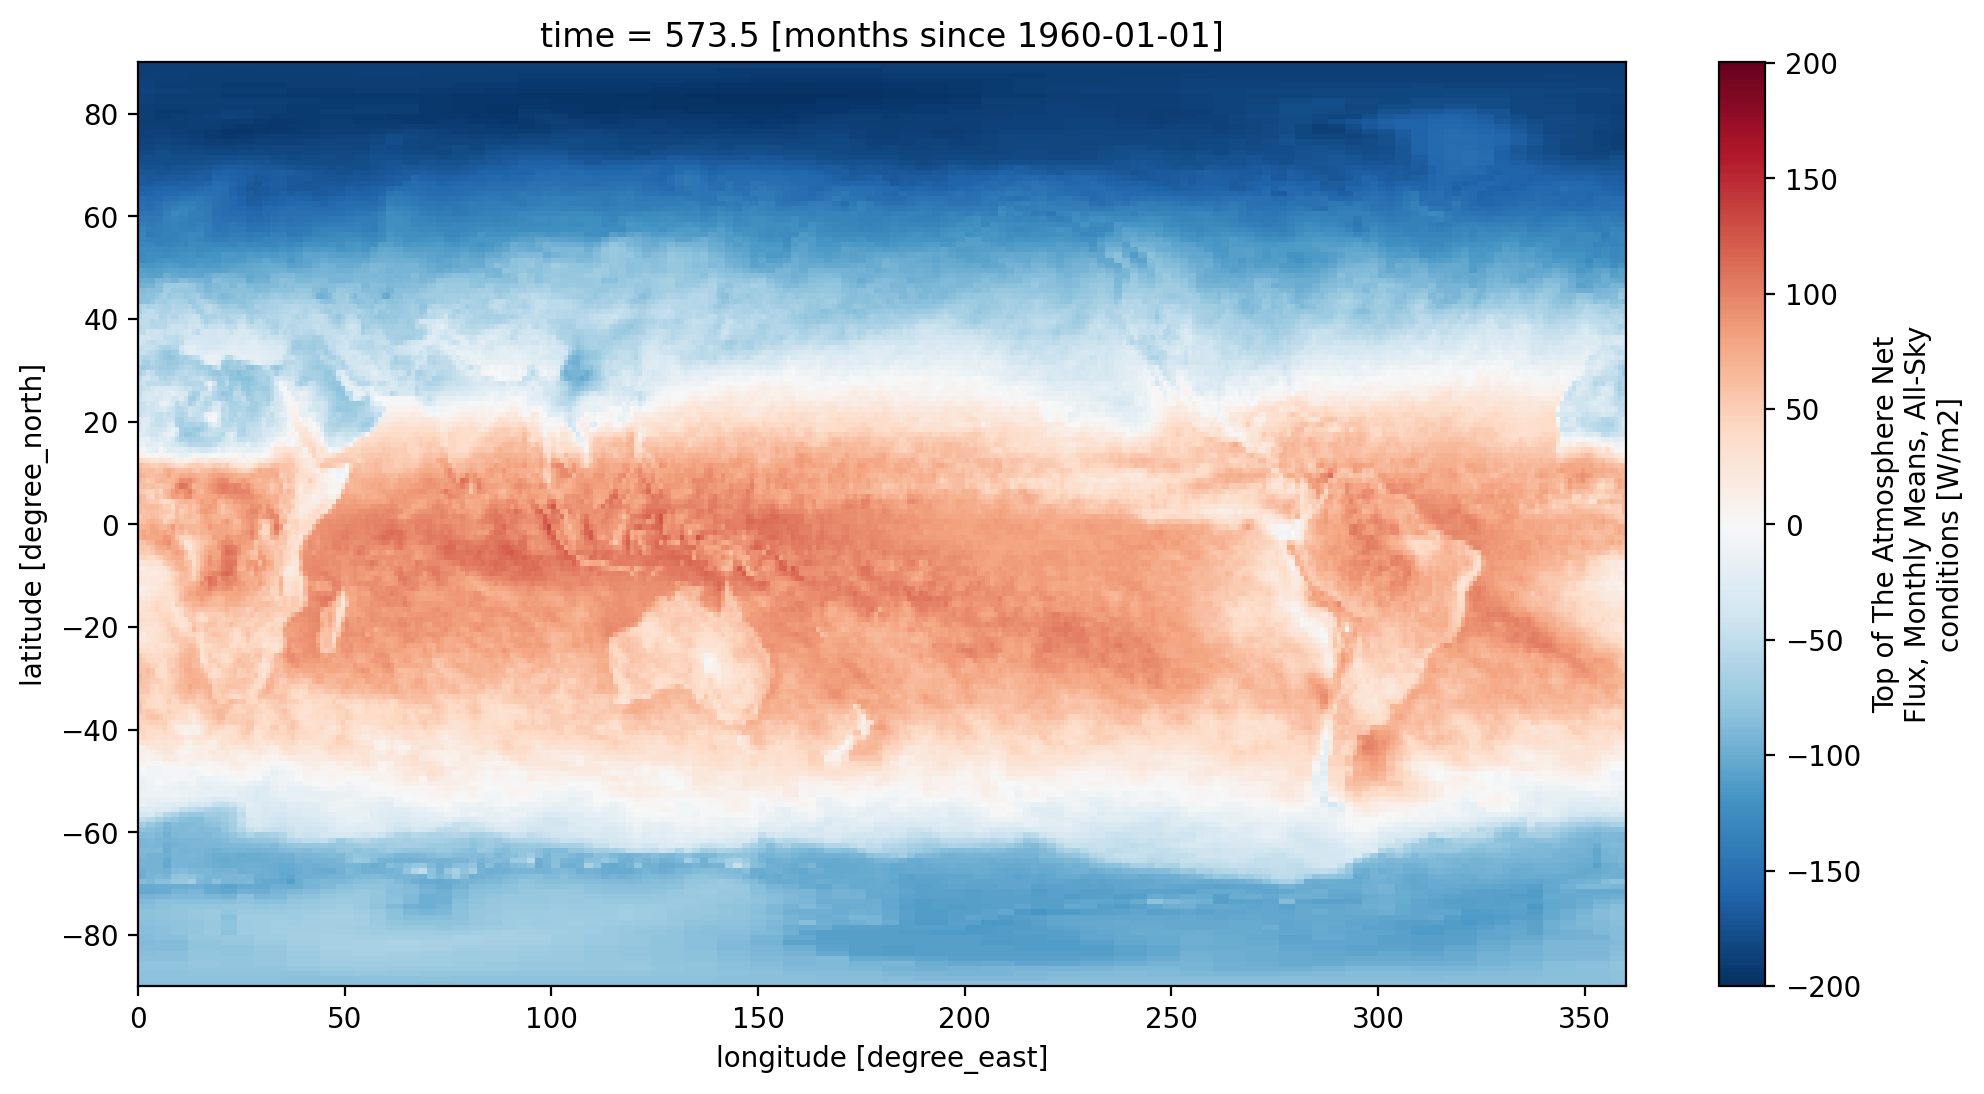

In [11]:
da.toa_net_all_mon.sel(time=time_mean).plot()

"""
net_data_slice = net.isel(time=0)
plt.imshow(net_data_slice,vmin=-200, vmax=200)

cbar = plt.colorbar()
cbar.ax.invert_yaxis()
"""

## 3) Mean and weighted mean

### 3.1) Calculate the global (unweighted) mean of TOA net radiation

Since the Earth is approximately in radiative balance, the net TOA radiation should be zero. But taking the naive mean from this dataset, you should find a number far from zero. Why?

In [12]:
da.toa_net_all_mon.mean(dim=('lon', 'lat'))

<xarray.DataArray 'toa_net_all_mon' (time: 183)> Size: 732B
array([-31.831694, -31.732458, -30.475706, -27.045414, -24.851843,
       -31.55399 , -36.750584, -34.389668, -26.737629, -20.029846,
       -18.874207, -26.565619, -30.952093, -31.98687 , -30.939749,
       -27.680552, -25.410667, -31.932974, -36.258694, -34.273823,
       -26.484793, -21.069649, -21.05221 , -25.960169, -32.668316,
       -32.554657, -31.334854, -27.670834, -27.369484, -32.900284,
       -37.73456 , -34.53416 , -26.66852 , -20.698528, -21.06908 ,
       -25.618086, -31.74429 , -32.366722, -30.887108, -26.99021 ,
       -25.124037, -31.04521 , -36.203693, -34.76852 , -26.552273,
       -20.625683, -20.62925 , -25.75974 , -32.333992, -31.786388,
       -31.37509 , -28.32504 , -25.023708, -31.563108, -36.227085,
       -34.591095, -25.683125, -18.675617, -20.694664, -26.466152,
       -32.2365  , -32.21694 , -29.65338 , -27.046597, -26.48103 ,
       -31.631338, -36.466118, -34.77507 , -26.791859, -20.09491 ,
       -21.21224 , -26.099371, -31.783901, -31.977303, -29.213097,
       -26.942455, -25.977665, -32.332935, -36.285904, -34.803474,
       -26.276001, -19.942486, -21.017866, -26.10423 , -32.34761 ,
       -32.3028  , -31.447254, -26.33199 , -25.543692, -31.464083,
       -37.02136 , -34.767467, -27.262735, -21.346567, -19.612427,
       -26.519917, -31.626675, -32.334225, -29.441063, -26.060274,
       -24.563196, -30.410305, -36.657894, -33.16116 , -26.653051,
       -19.03423 , -20.561035, -26.145826, -30.884035, -30.903952,
       -30.625647, -26.133568, -25.707848, -31.205648, -36.700348,
       -34.876915, -27.406473, -20.340239, -21.486828, -27.84885 ,
       -32.920135, -31.665585, -30.63119 , -26.005077, -25.267687,
       -31.816122, -36.89009 , -34.704838, -26.938412, -20.22727 ,
       -20.197254, -26.599155, -31.506172, -32.48346 , -29.802626,
       -26.14862 , -24.95626 , -31.24435 , -36.6698  , -33.267666,
       -26.387047, -20.799562, -20.271204, -25.020247, -32.223297,
       -31.512491, -29.191372, -25.17133 , -24.644945, -30.821367,
       -36.661575, -34.190186, -26.117916, -19.554749, -22.79161 ,
       -26.166553, -31.174835, -31.899431, -29.75585 , -27.125261,
       -25.730453, -31.933187, -37.825108, -34.78325 , -26.321648,
       -20.286034, -21.2802  , -27.061583, -32.314327, -31.997341,
       -30.272652, -27.391874, -26.362938, -30.615366, -36.32156 ,
       -34.43967 , -26.099268, -20.589674, -21.131338, -25.428139,
       -31.487776, -32.177814, -29.394464], dtype=float32)
Coordinates:
  * time     (time) float32 732B 482.5 483.5 484.5 485.5 ... 662.5 663.5 664.5

The answer is that each "pixel" or "grid point" of this dataset does not represent an equal area of Earth's surface. So naively taking the mean, i.e. giving equal weight to each point, gives the wrong answer.

On a lat / lon grid, the relative area of each grid point is proportional to $\cos(\phi)$. ($\phi$ is latitude)

### 3.2) Create a `weight` array proportional to $\cos(\phi)$

Think carefully a about radians vs. degrees


In [13]:
weight = np.cos(np.deg2rad(da.lat))
weight

<xarray.DataArray 'lat' (lat: 180)> Size: 720B
array([0.00872656, 0.02617699, 0.04361945, 0.06104851, 0.07845908,
       0.09584576, 0.11320324, 0.13052624, 0.14780948, 0.16504757,
       0.18223551, 0.19936794, 0.21643965, 0.23344542, 0.25037998,
       0.26723838, 0.28401536, 0.30070582, 0.3173047 , 0.33380693,
       0.35020736, 0.3665012 , 0.38268346, 0.3987491 , 0.4146933 ,
       0.43051115, 0.44619778, 0.4617486 , 0.47715878, 0.49242356,
       0.5075384 , 0.5224986 , 0.5372996 , 0.551937  , 0.56640625,
       0.58070296, 0.59482276, 0.6087614 , 0.62251467, 0.6360782 ,
       0.64944804, 0.66262007, 0.67559016, 0.68835455, 0.70090926,
       0.71325046, 0.72537434, 0.7372773 , 0.7489557 , 0.76040596,
       0.77162457, 0.78260815, 0.7933533 , 0.8038569 , 0.8141155 ,
       0.8241262 , 0.83388585, 0.8433914 , 0.85264015, 0.8616291 ,
       0.87035567, 0.87881714, 0.8870108 , 0.89493436, 0.90258527,
       0.9099613 , 0.9170601 , 0.9238795 , 0.9304176 , 0.9366722 ,
       0.9426415 , 0.94832367, 0.95371693, 0.95881975, 0.96363044,
       0.96814764, 0.9723699 , 0.976296  , 0.9799247 , 0.9832549 ,
       0.9862856 , 0.9890159 , 0.9914449 , 0.9935719 , 0.9953962 ,
       0.9969173 , 0.9981348 , 0.99904823, 0.99965733, 0.9999619 ,
       0.9999619 , 0.99965733, 0.99904823, 0.9981348 , 0.9969173 ,
       0.9953962 , 0.9935719 , 0.9914449 , 0.9890159 , 0.9862856 ,
       0.9832549 , 0.9799247 , 0.976296  , 0.9723699 , 0.96814764,
       0.96363044, 0.95881975, 0.95371693, 0.94832367, 0.9426415 ,
       0.9366722 , 0.9304176 , 0.9238795 , 0.9170601 , 0.9099613 ,
       0.90258527, 0.89493436, 0.8870108 , 0.87881714, 0.87035567,
       0.8616291 , 0.85264015, 0.8433914 , 0.83388585, 0.8241262 ,
       0.8141155 , 0.8038569 , 0.7933533 , 0.78260815, 0.77162457,
       0.76040596, 0.7489557 , 0.7372773 , 0.72537434, 0.71325046,
       0.70090926, 0.68835455, 0.67559016, 0.66262007, 0.64944804,
       0.6360782 , 0.62251467, 0.6087614 , 0.59482276, 0.58070296,
       0.56640625, 0.551937  , 0.5372996 , 0.5224986 , 0.5075384 ,
       0.49242356, 0.47715878, 0.4617486 , 0.44619778, 0.43051115,
       0.4146933 , 0.3987491 , 0.38268346, 0.3665012 , 0.35020736,
       0.33380693, 0.3173047 , 0.30070582, 0.28401536, 0.26723838,
       0.25037998, 0.23344542, 0.21643965, 0.19936794, 0.18223551,
       0.16504757, 0.14780948, 0.13052624, 0.11320324, 0.09584576,
       0.07845908, 0.06104851, 0.04361945, 0.02617699, 0.00872656],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    pointwidth:     1.0
    standard_name:  latitude
    gridtype:       0
    units:          degree_north

### 3.3) Redo your global mean TOA net radiation calculation with this weight factor

Use xarray's [weighted array reductions](http://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions) to compute the weighted mean.

In [14]:
da.toa_net_all_mon.weighted(weight).mean(dim=('lon', 'lat'))

<xarray.DataArray 'toa_net_all_mon' (time: 183)> Size: 732B
array([  7.248061  ,   2.3332667 ,  -5.6247797 ,  -9.633694  ,
        -7.6852107 ,  -4.1550765 ,   0.07194033,   2.4783826 ,
         4.4059453 ,   6.177352  ,   9.720135  ,   9.290612  ,
         8.102658  ,   1.424409  ,  -5.799099  ,  -8.643452  ,
        -7.8867373 ,  -5.336163  ,   0.6808901 ,   1.7276514 ,
         3.8606665 ,   5.3461127 ,   8.094753  ,   8.651125  ,
         7.5638857 ,   1.1524818 ,  -5.408398  ,  -9.89336   ,
        -9.808342  ,  -5.941855  ,  -0.33848646,   3.0717661 ,
         3.9487514 ,   5.6374383 ,   7.3718925 ,   8.849657  ,
         6.982631  ,   1.5766383 ,  -6.181146  ,  -9.422141  ,
        -8.564229  ,  -4.0316854 ,   0.36374113,   2.123114  ,
         3.9246082 ,   5.540496  ,   8.40755   ,   9.075402  ,
         6.0246406 ,   2.2666233 ,  -6.5334682 , -10.722356  ,
        -7.6982694 ,  -4.4120193 ,   0.6521475 ,   2.061828  ,
         4.228815  ,   6.934646  ,   7.8449273 ,   8.222451  ,
         6.9496217 ,   1.3396615 ,  -4.5133195 ,  -9.957795  ,
        -9.412199  ,  -5.045677  ,   0.34377447,   1.959597  ,
         3.6790354 ,   6.671392  ,   8.283402  ,   8.974908  ,
         7.1824474 ,   2.225769  ,  -4.448258  ,  -9.470749  ,
        -9.005831  ,  -5.107243  ,   0.3301166 ,   1.7711709 ,
...
         3.6697788 ,   6.9349313 ,   8.578816  ,   9.633012  ,
         8.205481  ,   1.9925319 ,  -4.7670703 ,  -7.8901205 ,
        -8.61203   ,  -4.6180162 ,  -0.28040922,   2.1268656 ,
         3.18413   ,   6.1705766 ,   6.3937793 ,   8.013613  ,
         6.2836924 ,   2.1747315 ,  -6.0349092 ,  -9.873676  ,
        -9.119863  ,  -5.546443  ,  -0.1557455 ,   2.0486126 ,
         3.0486746 ,   5.71662   ,   8.43866   ,   8.329081  ,
         7.452157  ,   2.2674193 ,  -4.5418406 ,  -9.861023  ,
        -8.914101  ,  -4.88828   ,  -0.40596408,   3.5880973 ,
         4.074947  ,   4.880007  ,   8.592837  ,  10.782234  ,
         7.076631  ,   2.627862  ,  -4.4597883 ,  -9.067578  ,
        -8.202155  ,  -4.1777697 ,   0.14197314,   3.1336317 ,
         4.6546884 ,   7.0046873 ,   6.7247047 ,   8.455267  ,
         7.904793  ,   1.5472249 ,  -5.016067  ,  -9.973448  ,
        -8.547048  ,  -4.612141  ,  -0.09913955,   2.123162  ,
         4.0603857 ,   6.015327  ,   7.543046  ,   8.198423  ,
         7.2288666 ,   2.195561  ,  -4.8626423 , -10.086276  ,
        -9.601099  ,  -3.917057  ,   0.6867787 ,   2.507695  ,
         4.408518  ,   5.566626  ,   7.1450887 ,   9.377934  ,
         7.597979  ,   2.4429524 ,  -4.407378  ], dtype=float32)
Coordinates:
  * time     (time) float32 732B 482.5 483.5 484.5 485.5 ... 662.5 663.5 664.5

This time around, you should have found something much closer to zero. Ask a climate scientist what the net energy imbalance of Earth due to global warming is estimated to be. Do you think our calculation is precise enough to detect this? 

### 3.4) Now that you have a `weight` factor, verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with infographic shown in the first cell of this assignment

In [15]:
#???
lw_weighted = da.toa_lw_all_mon.weighted(weight).mean(dim=('lon', 'lat'))
sw_weighted = da.toa_sw_all_mon.weighted(weight).mean(dim=('lon', 'lat'))
solar_weighted = da.solar_mon.weighted(weight).mean(dim=('lon', 'lat'))
net_weighted =  -lw_weighted - sw_weighted + solar_weighted
total_sum = np.sum(net_weighted)
print(total_sum)

<xarray.DataArray ()> Size: 4B
array(159.03967, dtype=float32)


## 4) Meridional Heat Transport Calculation

We can go beyond a weight factor and actually calculate the area of each pixel of the dataset, using the formula

$$ dA = R^2 \cos(\phi) d\lambda d \phi $$

where $d\lambda$ and $d\phi$ are the spacing of the points in longitude and latitude (measured in radians). We can approximate Earth's radius as $R = 6,371$ km.

### 4.1) calculate the pixel area using this formula and create a 2D (lon, lat) DataArray for it

(Xarray's `ones_like` function can help you easily create and broadcast DataArrays.) Verify that the sum of all the pixels equals the Earth's true surface area as evaluated using the formula for the area of a sphere (yes, the Earth is not a sphere ... it's just a homework problem).

In [16]:
R = 6371  # km
dphi = np.radians(da.lat[1] - da.lat[0])
dlambda = np.radians(da.lon[1] - da.lon[0])

lat_br = xr.ones_like(da.lat)
lat_rad = np.radians(lat_br)
cos_lat = np.cos(lat_rad)

pixel_area = R**2 * dphi * dlambda * cos_lat
pixel_area_2d = pixel_area.expand_dims(dim=['lon'], axis=0) 

print (pixel_area_2d)


<xarray.DataArray (lon: 1, lat: 180)> Size: 720B
array([[12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 12362.429,
        12362.429, 12362.429, 12362.429, 12362.429, 12362.429, 

In [17]:
area_da = xr.DataArray(np.tile(pixel_area_2d, (180, 1)), dims=["lat", "lon"])
area_da

<xarray.DataArray (lat: 180, lon: 180)> Size: 130kB
array([[12362.429, 12362.429, 12362.429, ..., 12362.429, 12362.429,
        12362.429],
       [12362.429, 12362.429, 12362.429, ..., 12362.429, 12362.429,
        12362.429],
       [12362.429, 12362.429, 12362.429, ..., 12362.429, 12362.429,
        12362.429],
       ...,
       [12362.429, 12362.429, 12362.429, ..., 12362.429, 12362.429,
        12362.429],
       [12362.429, 12362.429, 12362.429, ..., 12362.429, 12362.429,
        12362.429],
       [12362.429, 12362.429, 12362.429, ..., 12362.429, 12362.429,
        12362.429]], dtype=float32)
Dimensions without coordinates: lat, lon

In [18]:
total_pixel_area = area_da.sum(dim=["lat", "lon"])
earth_surface_area = 4 * np.pi * R**2
print(f"total_pixel_area: {total_pixel_area.values:.2e} km²")
print(f"earth_surface_area: {earth_surface_area:.2e} km²")

total_pixel_area: 4.01e+08 km²
earth_surface_area: 5.10e+08 km²



### 4.2) Calculate and plot the total amount of net radiation in each 1-degree latitude band
Multiplying the pixel area (m$^2$) from above with the radiative flux (W m$^{-2}$) gives you the total amount of radiation absorbed in each pixel in W.

Label with correct units.

Text(0, 0.5, 'Net Radiation [10^20 W]')

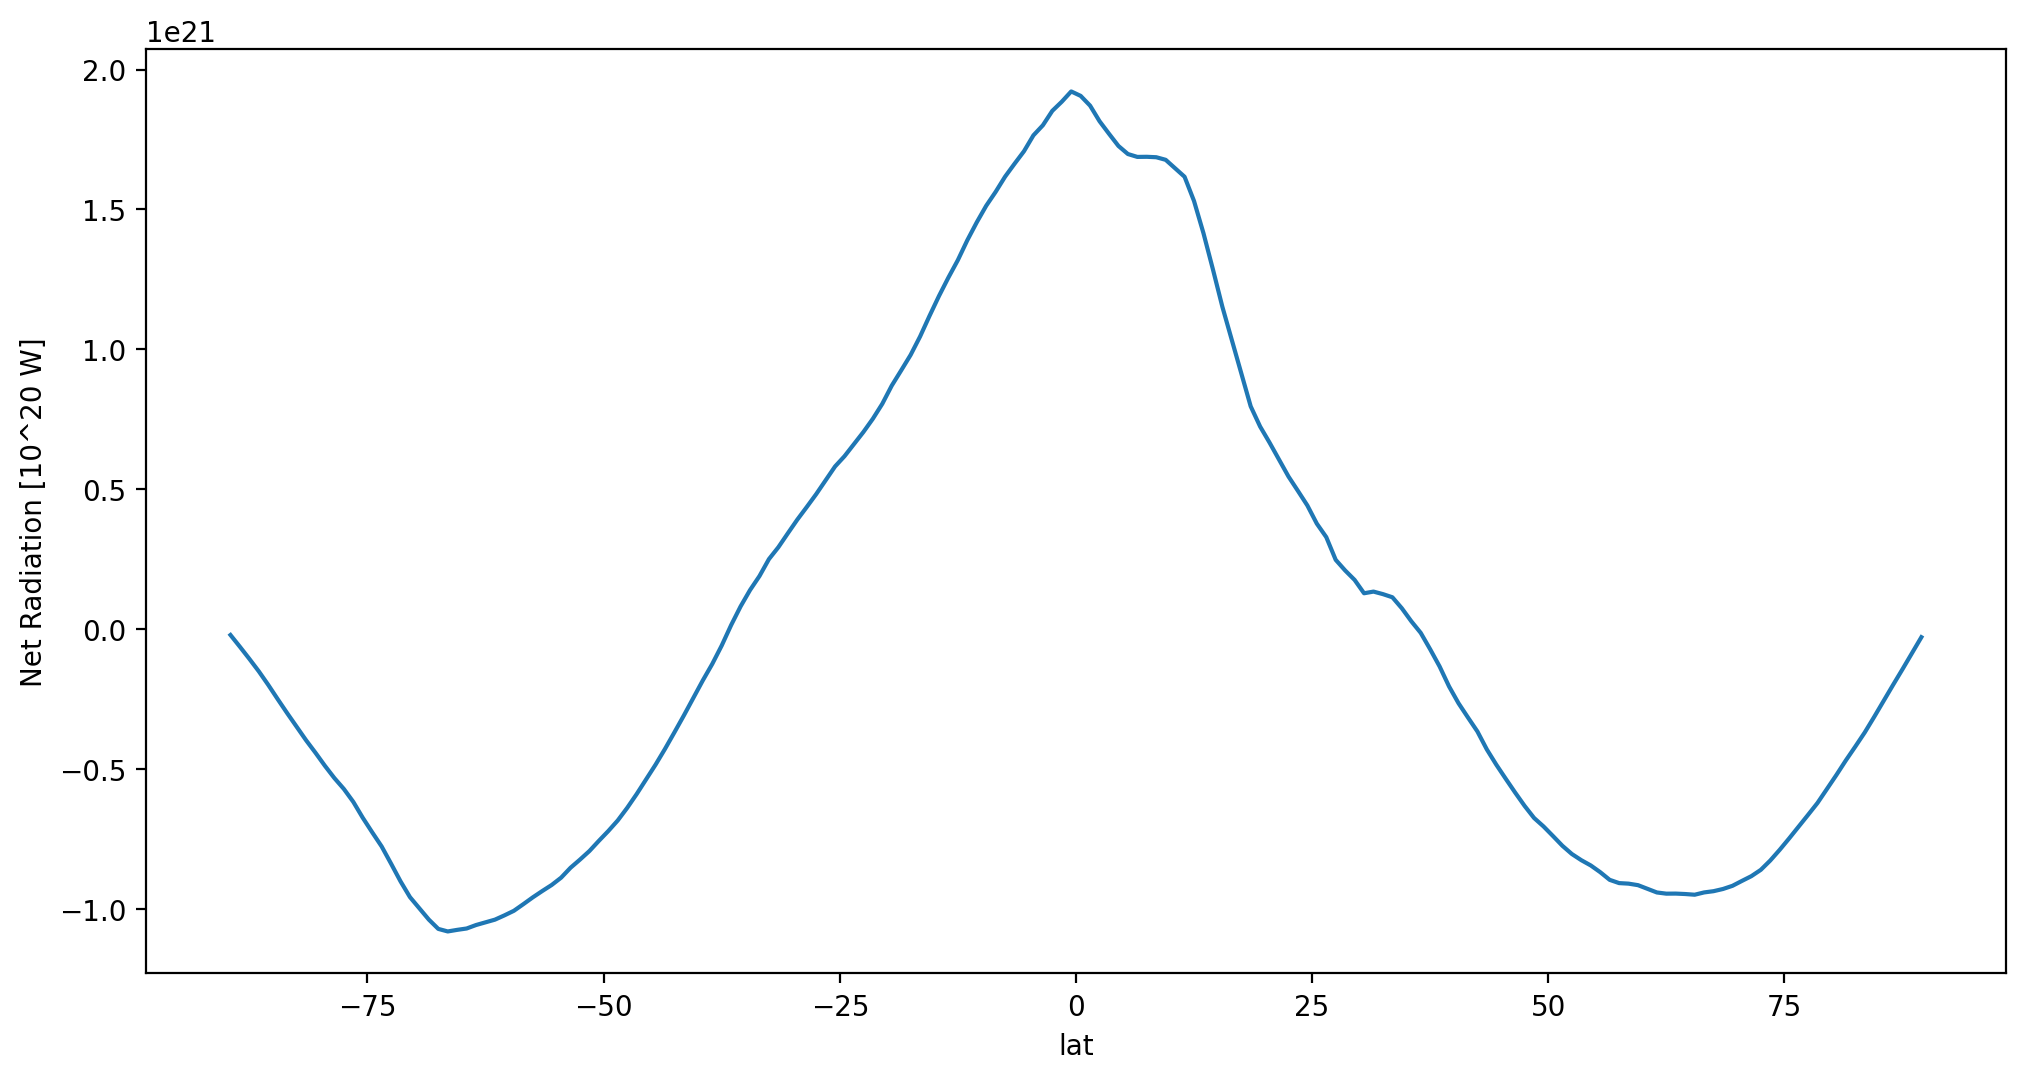

In [19]:
total_pixel_area_m = total_pixel_area*1000000
total_net_radiation = da.toa_net_all_mon.weighted(weight).sum(dim=['time', 'lon'])

(total_pixel_area_m * total_net_radiation).plot()
plt.ylabel('Net Radiation [10^20 W]')


### 4.3) Plot the cumulative sum of the total amount of net radiation as a function of latitude

Label with correct units. (Hint: check out xarray's [cumsum](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.cumsum.html) function.)

This curve tells you how much energy must be transported meridionally by the ocean and atmosphere in order to account for the radiative imbalance at the top of the atmosphere.

You should get a curve that looks something like this: https://journals.ametsoc.org/view/journals/clim/14/16/full-i1520-0442-14-16-3433-f07.gif (Figure from Trenberth & Caron, 2001)

Text(0, 0.5, 'Cumulative Net Radiation [W m^-2]')

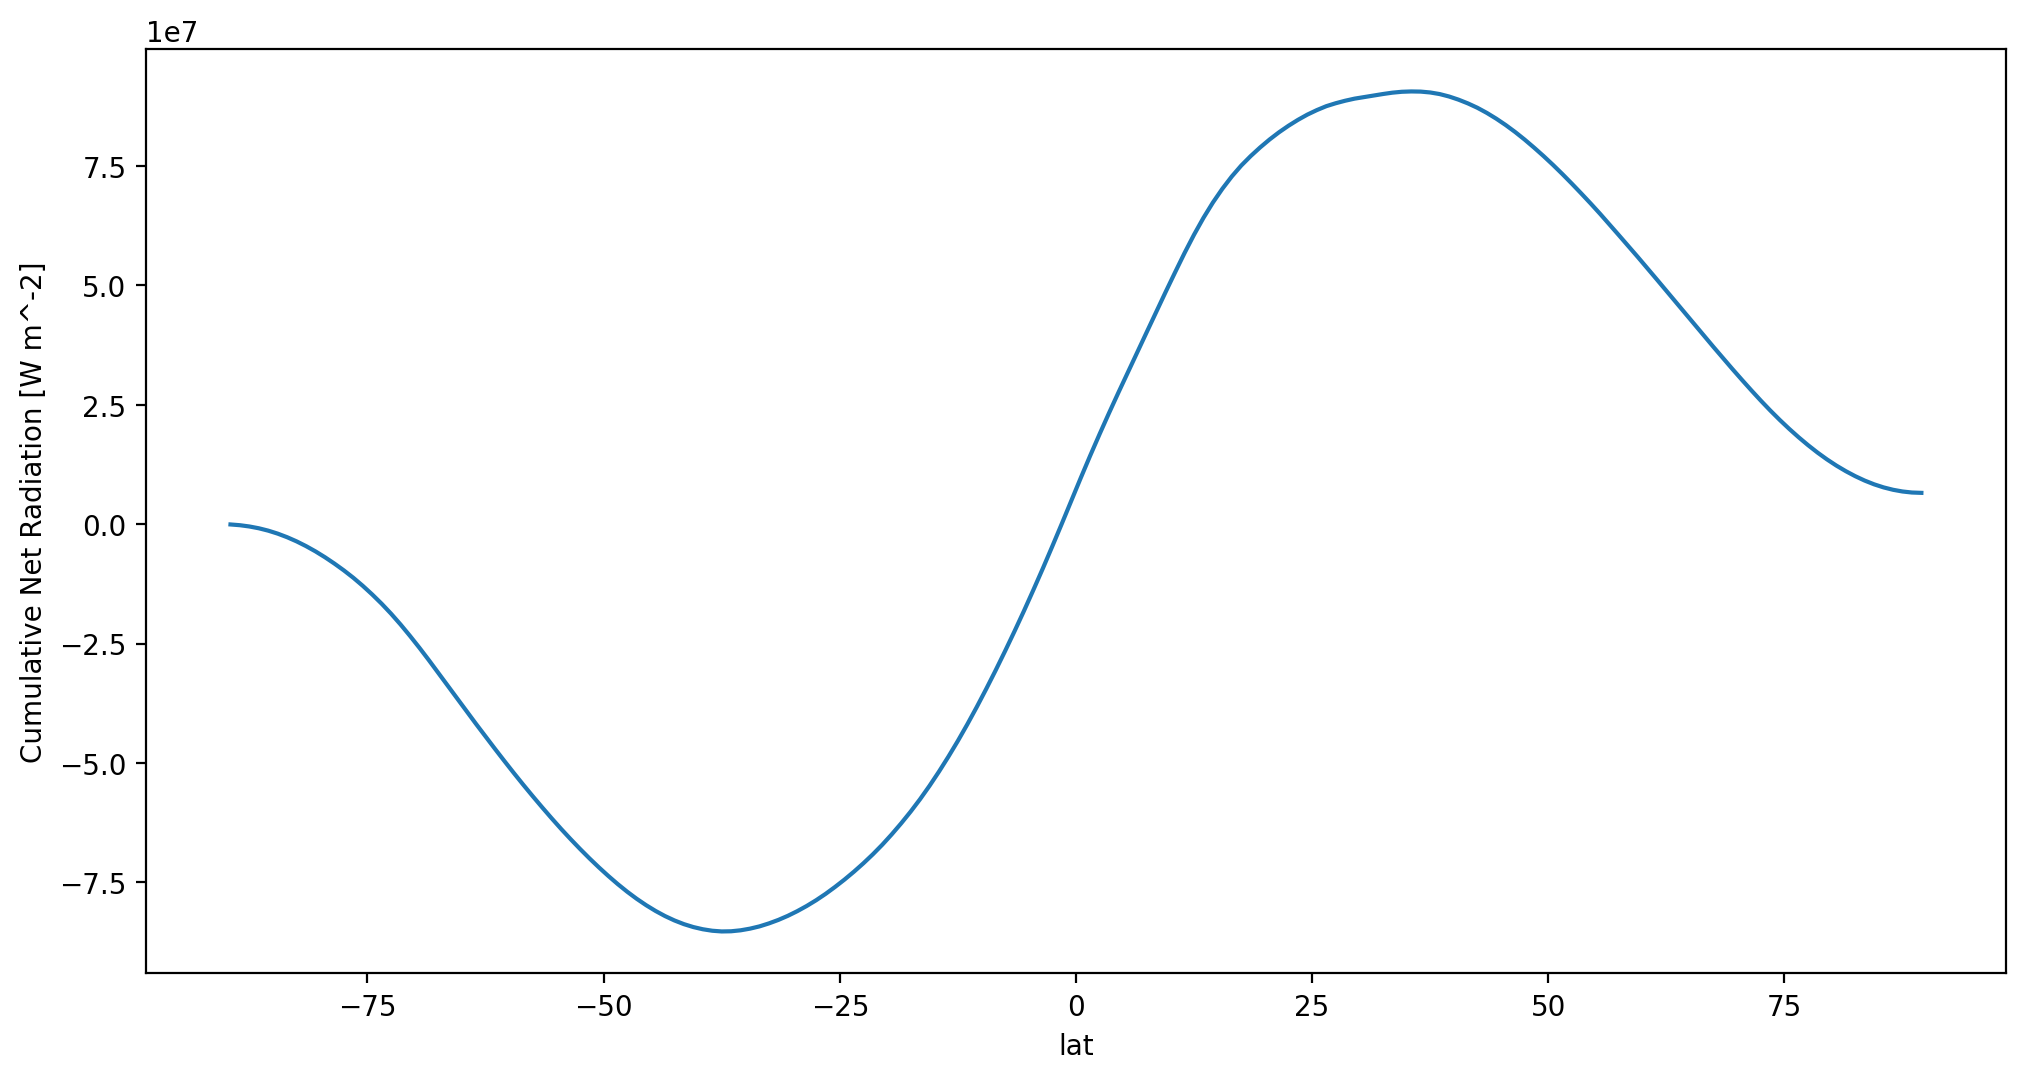

In [20]:
weighted_net_radiation = da.toa_net_all_mon.weighted(weight).sum(dim=['time', 'lon']) 

cumsum_net_radiation = weighted_net_radiation.cumsum(dim='lat')

cumsum_net_radiation.plot()

plt.ylabel("Cumulative Net Radiation [W m^-2]")

## 5) Selecting and Merging Data

For the next problem, use the following approximate locations of four different cities.

| city | lon | lat |
| -- | -- | -- |
| NYC |74 W | 40 N | 
| Nome, Alaska | 165 W | 64 N | 
| Columbo, Sri Lanka | 80 E | 7 N |
| Hobart, Tasmania | 147 E | 43 S |


### 5.1) Create a `Dataset` for each point from the global dataset
Each city should get its own `Dataset` with the same variables as the one you imported. Find the nearest associated incoming solar radiation and net radiation timeseries at each city.

In [21]:

city_coords = {
    'NYC': {'lon': 74+180, 'lat': 40}, 
    'Nome, Alaska': {'lon': 165+180, 'lat': 64},
    'Colombo, Sri Lanka': {'lon': 80, 'lat': 7},
    'Hobart, Tasmania': {'lon': 147, 'lat': -43},
}

city_datasets = {}
for city, coords in city_coords.items():

        incoming_sr = da.solar_mon.sel(
        lat=coords['lat'], lon=coords['lon'], method='nearest')
        net_r = da.toa_net_all_mon.sel(
        lat=coords['lat'], lon=coords['lon'], method='nearest')

        
        incoming_sr_weighted = incoming_sr.weighted(weight).mean(dim='lat')
        net_r_weighted = net_r.weighted(weight).mean(dim='lat')

        city_datasets[city] = xr.Dataset({
        'incoming_solar_radiation': incoming_sr_weighted,
        'net_radiation': net_r_weighted
    })

print(city_datasets['NYC'])


<xarray.Dataset> Size: 2kB
Dimensions:                   (time: 183)
Coordinates:
    lon                       float32 4B 254.5
  * time                      (time) float32 732B 482.5 483.5 ... 663.5 664.5
Data variables:
    incoming_solar_radiation  (time) float32 732B 321.2 401.6 ... 400.2 458.1
    net_radiation             (time) float32 732B -13.77 36.48 ... 29.88 50.72


### 5.2) Merge these four datasets into a new dataset with the new dimension `city`

Create a new dimension coordinate to hold the city name.
Display the merged dataset.

In [22]:
datasets_city_dim = []

for city, dataset in city_datasets.items():
   
    dataset_city_dim = dataset.expand_dims(city=1) 
    dataset_city_dim['City'] = city 
    datasets_city_dim.append(dataset_city_dim)


merged_dataset = xr.concat(datasets_city_dim, dim='city')
merged_dataset
#??????why 0.5

<xarray.Dataset> Size: 7kB
Dimensions:                   (city: 4, time: 183)
Coordinates:
    lon                       (city) float32 16B 254.5 345.5 80.5 147.5
  * time                      (time) float32 732B 482.5 483.5 ... 663.5 664.5
Dimensions without coordinates: city
Data variables:
    incoming_solar_radiation  (city, time) float32 3kB 321.2 401.6 ... 165.0
    net_radiation             (city, time) float32 3kB -13.77 36.48 ... -123.6
    City                      (city) <U18 288B 'NYC' ... 'Hobart, Tasmania'

### 5.3) Plot the incoming solar and net radiation at each city

Make two separate plots.
Try to have your legend created automatically from the data.

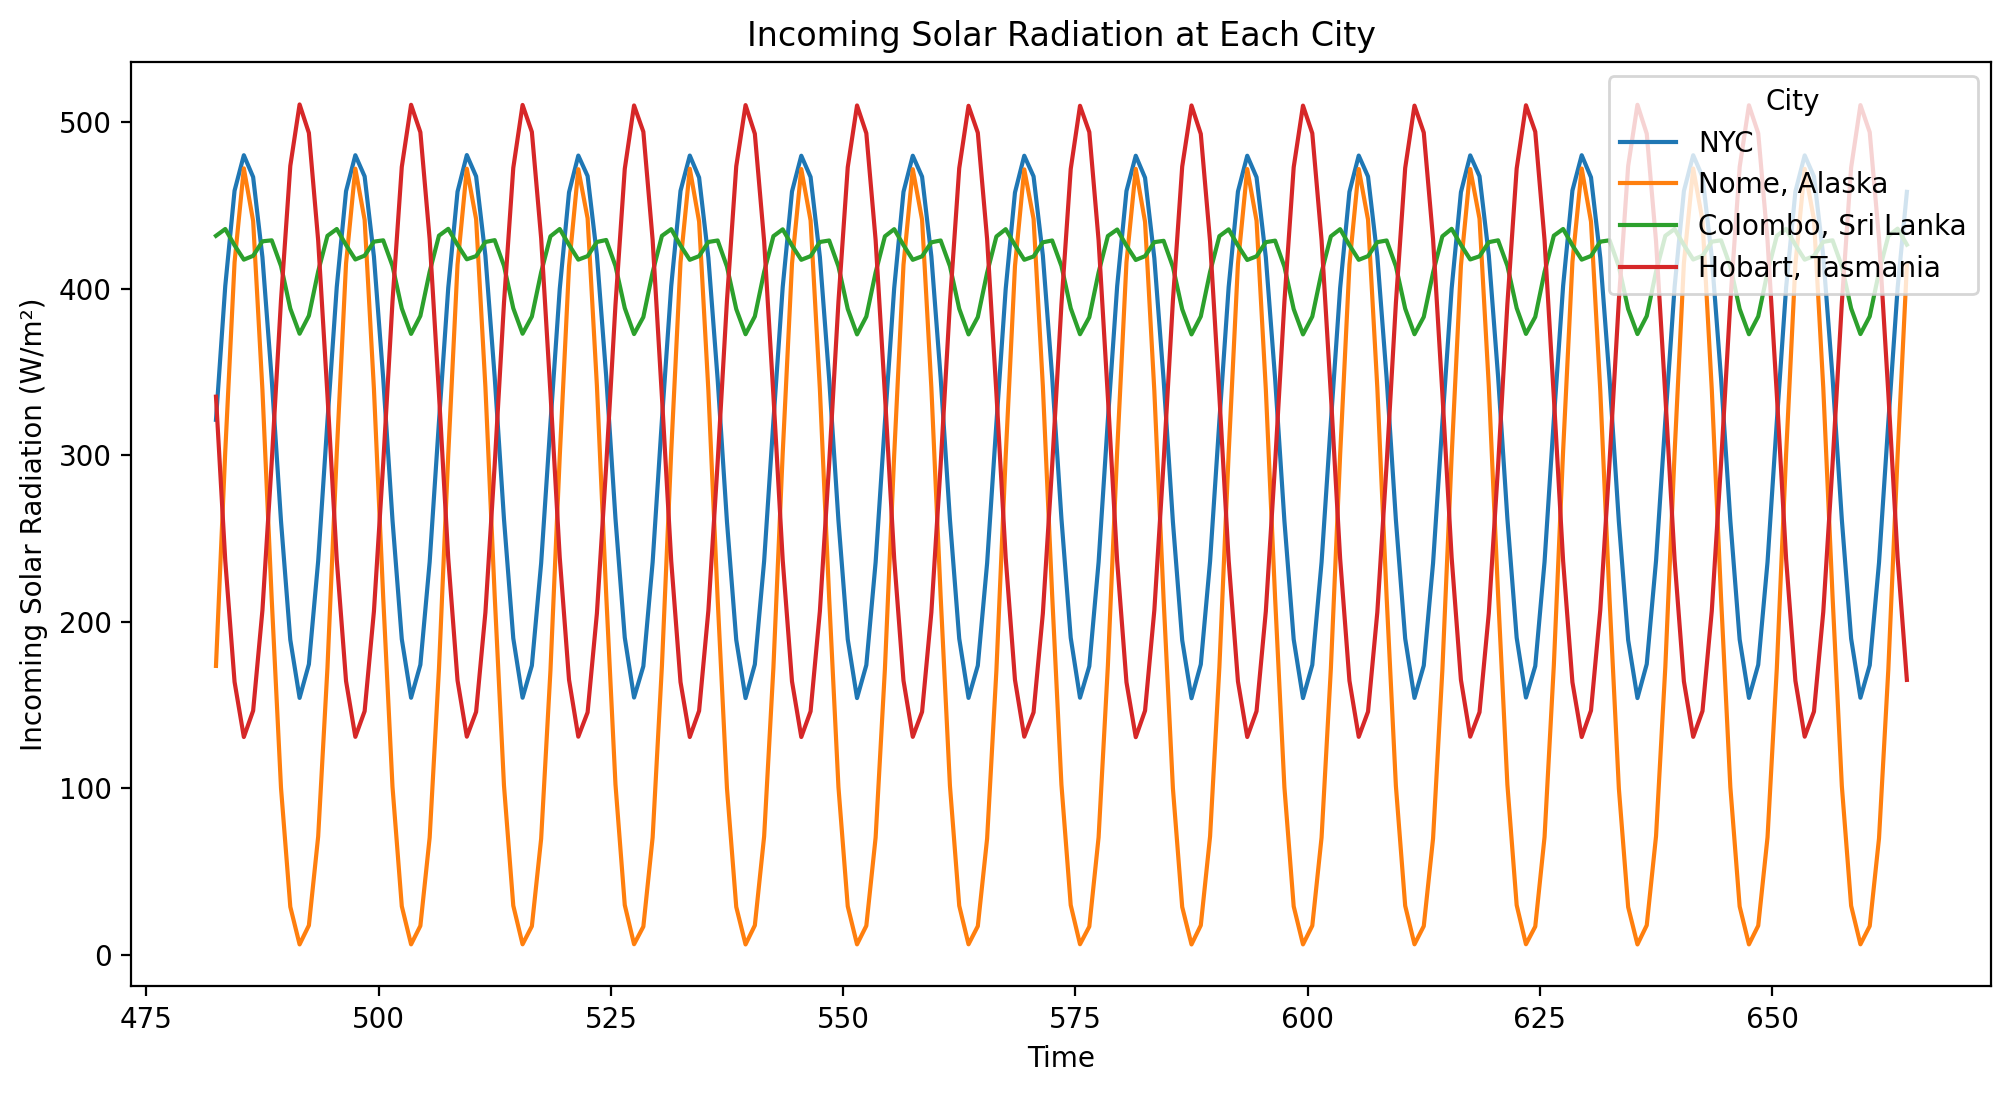

In [23]:
for city, dataset in city_datasets.items():
    incoming_radiation = dataset['incoming_solar_radiation']
    plt.plot(incoming_radiation.time, incoming_radiation, label=city)


plt.title('Incoming Solar Radiation at Each City')
plt.xlabel('Time')
plt.ylabel('Incoming Solar Radiation (W/m²)')


plt.legend(title='City', loc='upper right')
#legend?

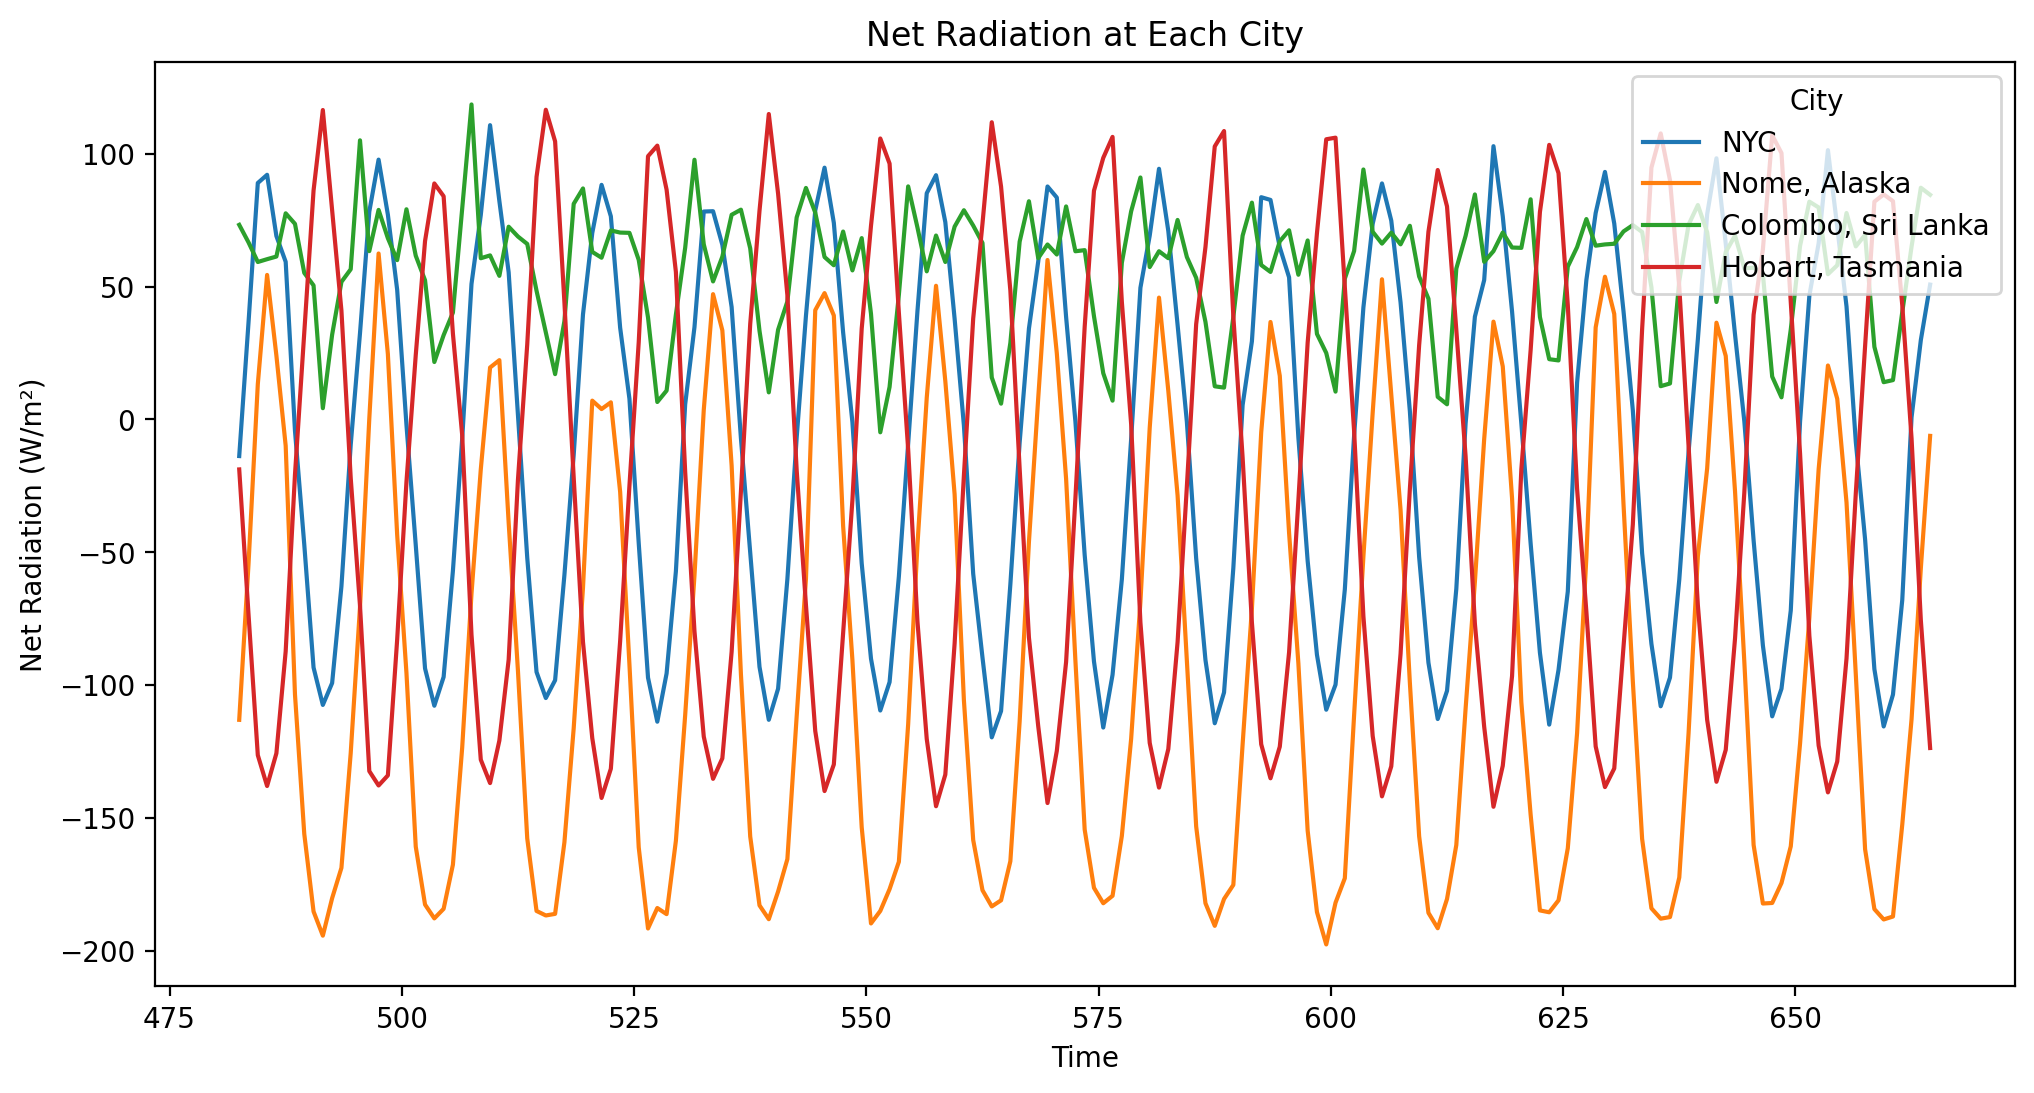

In [24]:

for city, dataset in city_datasets.items():
    net_radiation = dataset['net_radiation']
    plt.plot(net_radiation.time, net_radiation, label=city)

plt.title('Net Radiation at Each City')
plt.xlabel('Time')
plt.ylabel('Net Radiation (W/m²)')

plt.legend(title='City', loc='upper right')